In [1]:
import os
import numpy as np
import data.data_selector as ds
import utils.plot_functions as pf
import utils.data_processing as dp
import models.model_picker as mp
import matplotlib.pyplot as plt
from data.dataset import Dataset
import pickle
import imageio
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# model_type = mp.get_model('lca')
model_type='lca'

In [17]:
with np.load('/media/tbell/sanborn/rd_analysis/inputs/test_ft_white.npz') as d:
    data=d['arr_0'].item()

In [21]:
data['train'].images

array([[-8.02559027, -6.38574502, -4.97234298, ..., -0.79308134,
        -0.12300297, -1.66773607],
       [-1.78624423, -0.5065018 , -0.25324292, ..., -0.94931797,
        -0.68347017, -1.38217349],
       [-7.34116755, -3.53697381,  0.15289889, ...,  0.65846839,
         1.05977173, -0.08843569],
       ..., 
       [-0.23622818, -0.21544329, -0.64423774, ..., -2.44321694,
        -4.61059707, -8.87391291],
       [-1.05855154, -0.09975467, -1.38557076, ..., -1.34979829,
         1.72931997,  6.60563879],
       [ 5.97336677,  7.28153947,  2.11347017, ..., -0.16002263,
        -0.05984636, -2.62846022]])


# Field Dataset

## Overlapping Patches

In [35]:
params = {
  "num_patches": 100000,
  "patch_edge_size": 16,
  "num_pixels": 512,
  "num_images": 10
}

In [36]:
data = np.load("/media/tbell/datasets/field/IMAGES.npz")["IMAGES"].transpose((2,0,1))
data = np.reshape(data, (params["num_images"], params["num_pixels"], params["num_pixels"], 1))
patch_shape = (params["num_patches"], params["patch_edge_size"], params["patch_edge_size"], 1)
img_patches = dp.extract_patches(data, patch_shape, overlapping=True, randomize=True, var_thresh=1e-6)
images = Dataset(img_patches, lbls=None, ignore_lbls=None)
dataset = {'train': images}
reshaped = model.reshape_dataset(dataset, params)
img_patches = np.reshape(img_patches, (params["num_patches"], params["patch_edge_size"]**2))

In [101]:
np.savez( "/media/tbell/sanborn/rd_analysis/inputs/field_100k_patches.npz", reshaped)

In [103]:
pickle.dump(img_patches, open( "/media/tbell/sanborn/rd_analysis/inputs/field_100k_patches.p", "wb" ))

## Tiled Patches

In [4]:
params = {
  "num_patches": 1024,
  "patch_edge_size": 16,
  "num_pixels": 512,
  "num_images": 1,
  "img_idx": 0
}

In [51]:
data = np.load("/media/tbell/datasets/field/IMAGES.npz")["IMAGES"].transpose((2,0,1))[params["img_idx"]]
data = np.reshape(data, (1, params["num_pixels"], params["num_pixels"], 1))

In [52]:
patch_shape = (params["num_patches"], params["patch_edge_size"], params["patch_edge_size"], 1)
img_patches = dp.extract_patches(data, patch_shape, overlapping=False, randomize=False, var_thresh=1e-6)
images = Dataset(img_patches, lbls=None, ignore_lbls=None)
dataset = {'train': images}
reshaped = model.reshape_dataset(dataset, params)
img_patches = np.reshape(img_patches, (params["num_patches"], params["patch_edge_size"]**2))

In [56]:
np.savez( "/media/tbell/sanborn/rd_analysis/inputs/field_tiled_patches.npz", reshaped)

In [59]:
pickle.dump(img_patches, open( "/media/tbell/sanborn/rd_analysis/inputs/field_tiled_patches.p", "wb" ))

# No whitening

In [60]:
params = {
  "data_type": "vanHateren",
  "num_images": 100,
  "extract_patches": True,
  "patch_edge_size": 3,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 0,
  "norm_images": False,
  "whiten_data": False,
  "center_data": True,
  "whiten_method": None,
  "contrast_normalize": False,
  "standardize_data": True,
  "data_dir": "/media/tbell/datasets"
}

In [136]:
num_rows=1024
nyq = np.int32(np.floor(num_rows/2))
freqs = np.linspace(-nyq, nyq-1, num=num_rows)
fspace = np.meshgrid(freqs, freqs)
rho = np.sqrt(np.square(fspace[0]) + np.square(fspace[1]))
inv = np.zeros(rho.shape)
for i, a in enumerate(rho):
    for j, b in enumerate(a):
        inv[i, j] = b ** -1 if b != 0 else 0
# inv = rho ** -1
# nans = np.isnan(inv)
# inv[nans] = 0

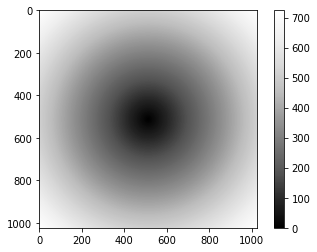

In [107]:
plt.imshow(rho, cmap='Greys_r')
plt.colorbar()

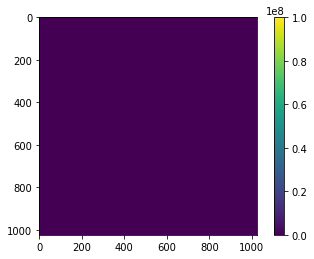

In [120]:
plt.imshow((rho+1e-8)**-1)
plt.colorbar()

In [114]:
inv = rho**-1

/home/sanborn/virtual_envs/py3/lib/python3.4/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  """Entry point for launching an IPython kernel.


In [121]:
nans = np.isnan(inv)
inv[nans] = 0

In [92]:
for i, a in enumerate(rho):
    for j, b in enumerate(a):
        inv[i, j] = b**-1 if b != 0 else 0

In [91]:
inv = np.zeros(rho.shape)

In [134]:
np.where(np.isnan(inv))

(array([], dtype=int64), array([], dtype=int64))

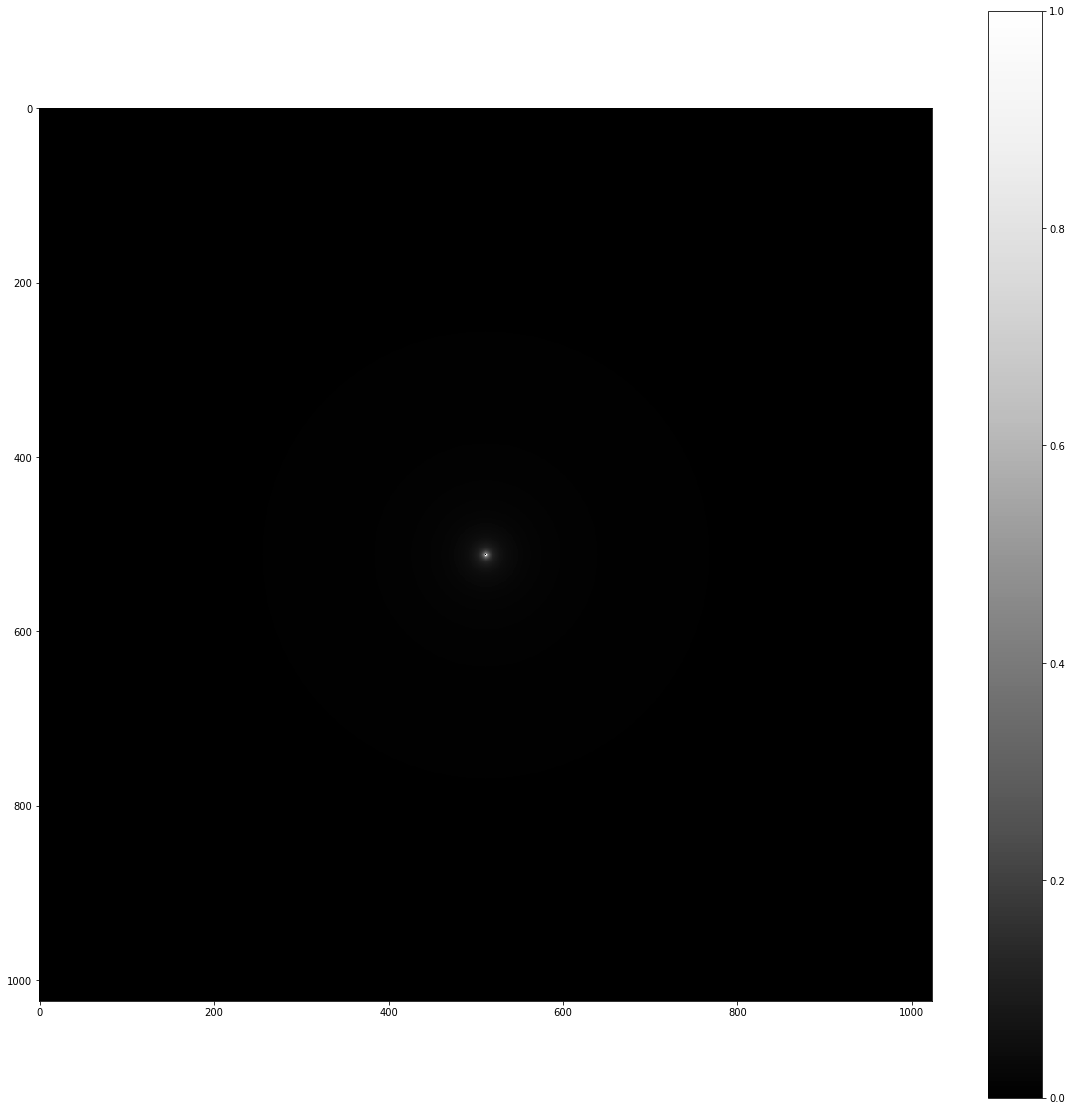

In [138]:
plt.rcParams["figure.figsize"] = [20,20]
plt.imshow(inv, cmap="Greys_r")
plt.colorbar()

In [61]:
params["num_patches"] = 100000
params["out_dir"] = "/media/tbell/sanborn/datasets/vh100k_3x3.p"

In [62]:
model = mp.get_model(model_type)
dataset = ds.get_data(params)

In [63]:
dataset['train'].images, data_mean, data_std = dp.standardize_data(dataset['train'].images)

In [64]:
for key in dataset.keys():
    out_shape = (int(params["num_patches"]), int(params["patch_edge_size"]),
      int(params["patch_edge_size"]), dataset[key].num_channels)
    dataset[key].num_examples = out_shape[0]
    dataset[key].reset_counters()
    dataset[key].images = dp.extract_patches(dataset[key].images, out_shape,
      params["overlapping_patches"], params["randomize_patches"],
      params["patch_variance_threshold"], dataset[key].rand_state)
    dataset[key].shape = dataset[key].images.shape
    dataset[key].num_rows = dataset[key].shape[1]
    dataset[key].num_cols = dataset[key].shape[2]
    dataset[key].num_channels = dataset[key].shape[3]
    dataset[key].num_pixels = np.prod(dataset[key].shape[1:])
    dataset[key].images = dp.reshape_data(dataset[key].images, flatten=None)[0] # reshapes to 4D (not flat) or 2D (flat)
    data_axis=tuple(range(dataset[key].images.ndim)[1:])
#     data_mean = np.mean(dataset[key].images, axis=data_axis, keepdims=True)
#     dataset[key].images = (dataset[key].images - data_mean)
#     images, dataset[key].data_mean, dataset[key].data_std = \
#         dp.standardize_data(dataset[key].images)
#     data_mean = dataset[key].data_mean
#     data_std = dataset[key].data_std
#     dataset[key].images, dataset[key].data_mean, dataset[key].data_std = \
#           dp.standardize_data(dataset[key].images)

In [65]:
dataset['train'].images, data_mean = dp.center_data(dataset['train'].images)

In [66]:
dataset = model.reshape_dataset(dataset, params)

In [29]:
dataset['train'].images.shape

(100000, 4)

In [16]:
np.savez(params["out_dir"], dataset['train'].images)

In [67]:
with open(params['out_dir'], 'wb') as handle:
    pickle.dump(dataset['train'].images, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
np.std(dataset['train'].images)

-3.6424067e-10

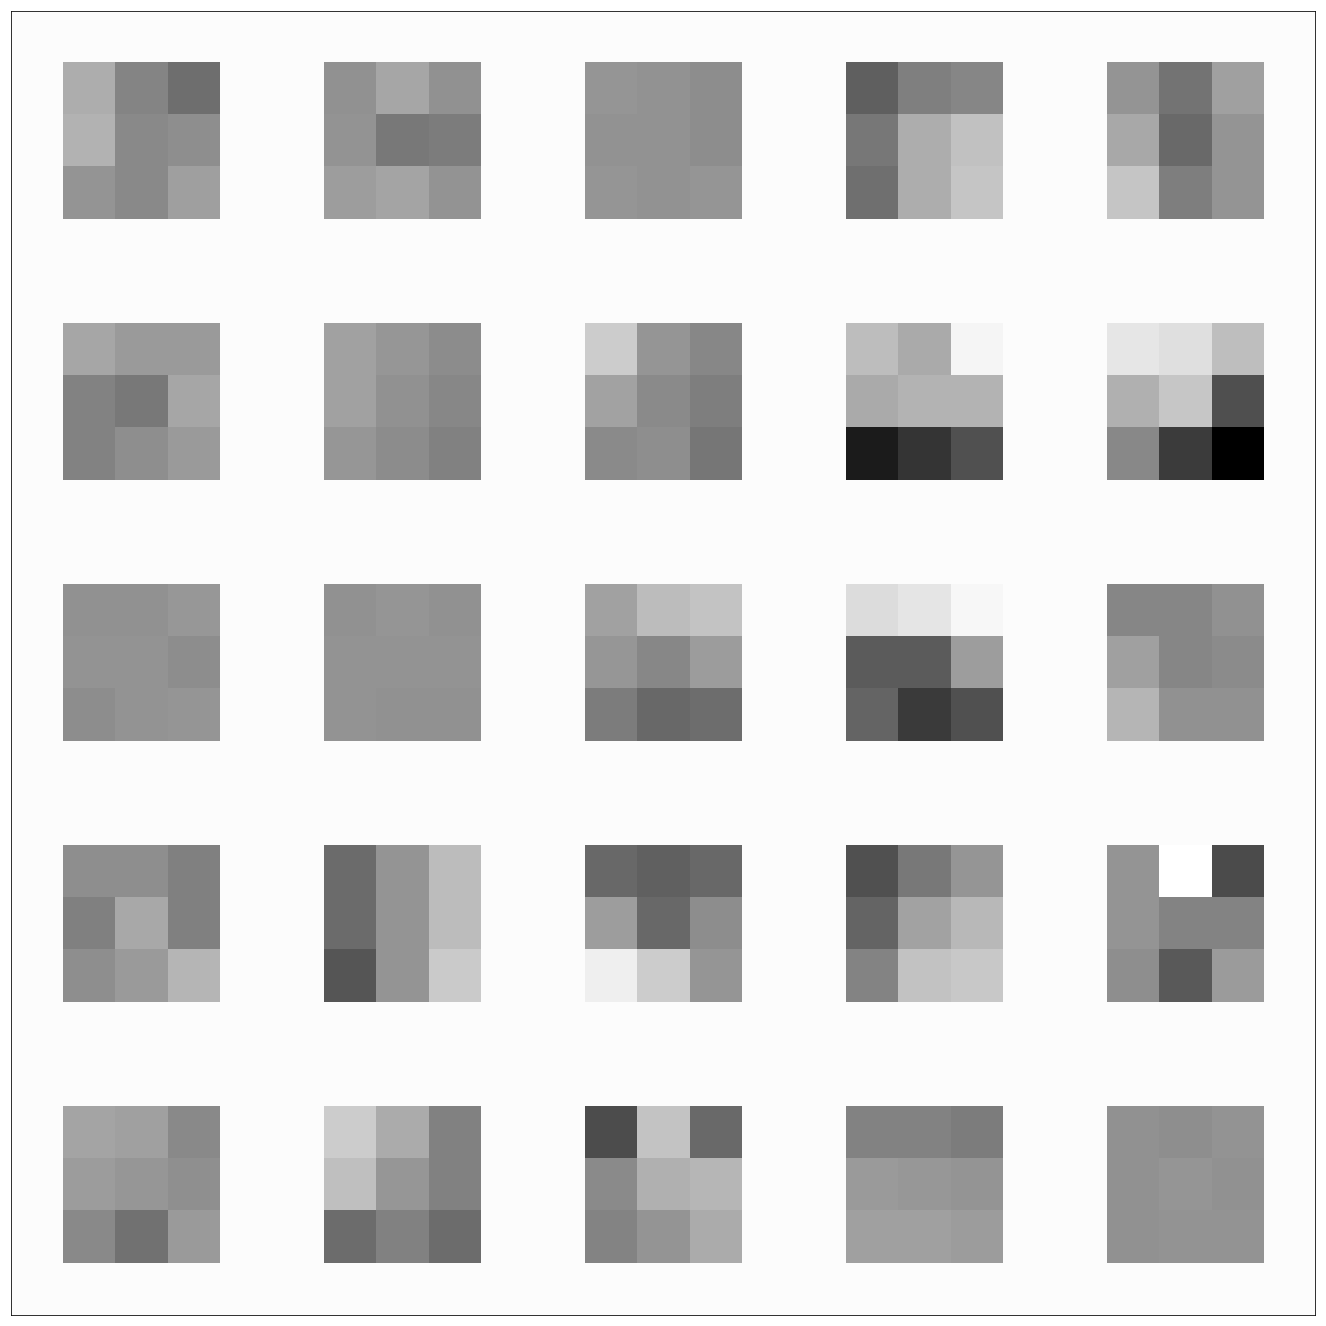

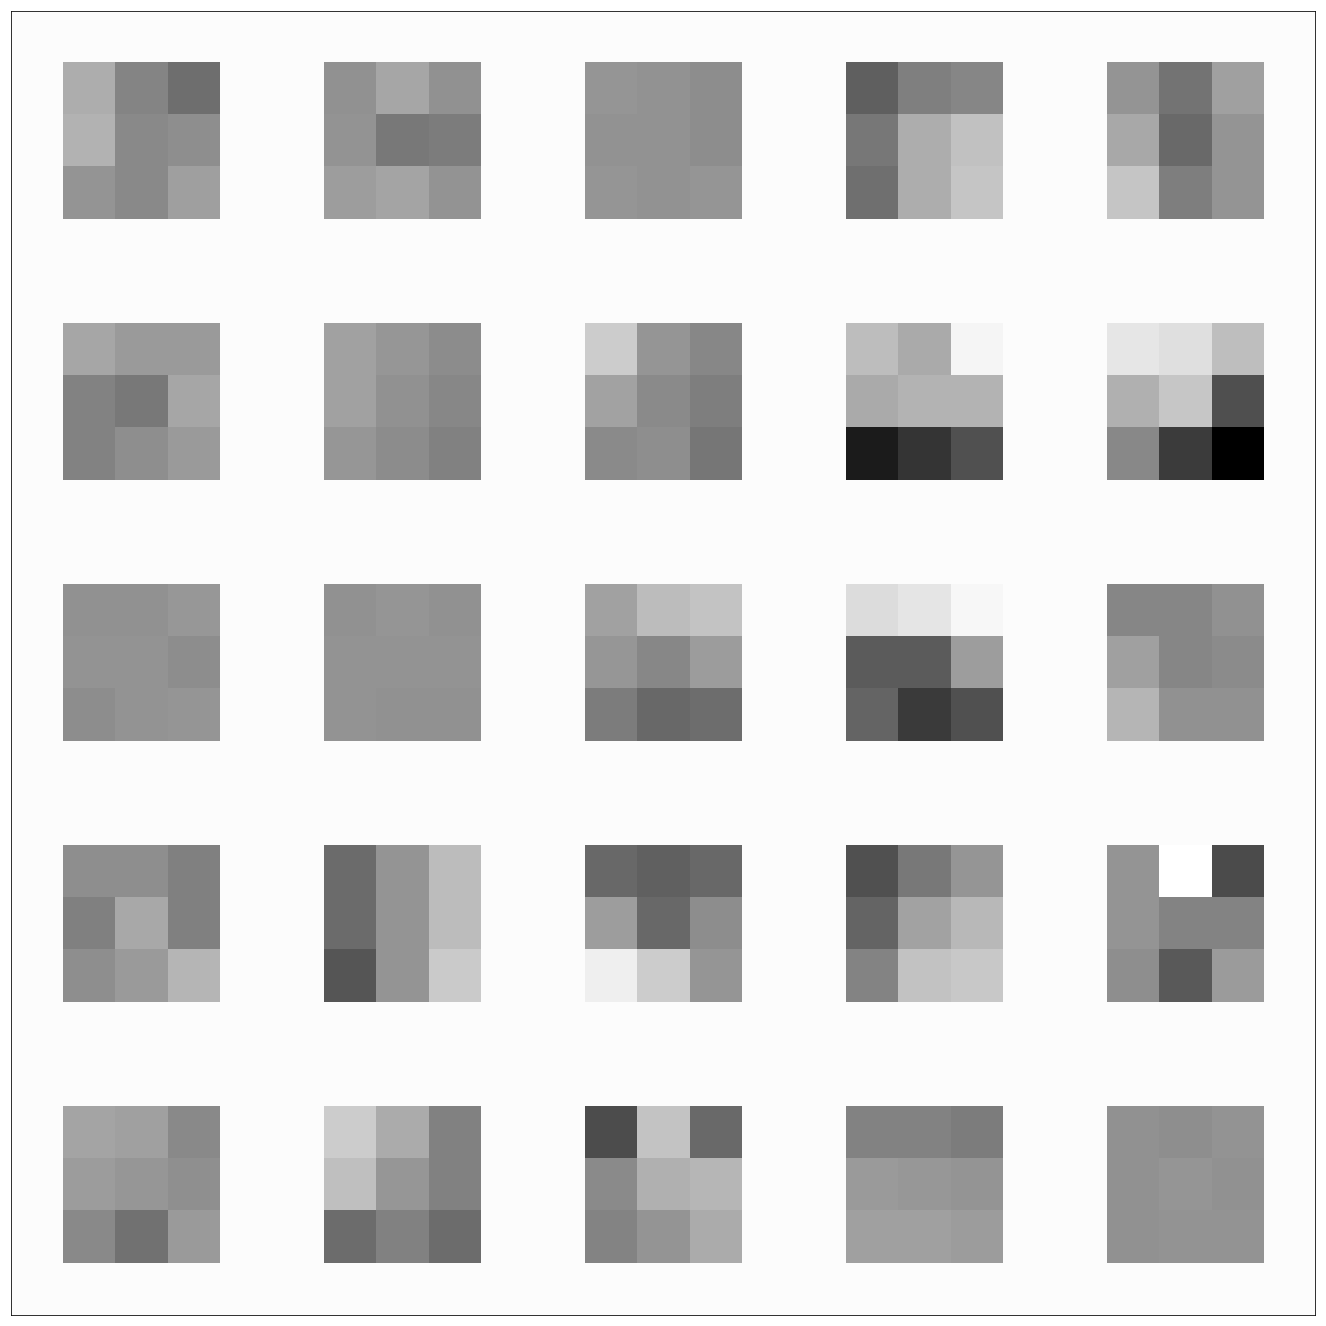

In [19]:
pf.plot_data_tiled(dataset['train'].images[:25])

## Training data

In [5]:
params["num_patches"] = 1000000
params["out_dir"] = "/media/tbell/sanborn/rd_analysis/inputs/train_nw_fresh.npz"

model = mp.get_model(model_type)
data = ds.get_data(params)
data = model.preprocess_dataset(data, params)
data = model.reshape_dataset(data, params)

In [10]:
np.std(np.reshape(data["train"].images, (100000, 256)), axis=1)

array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32)

In [7]:
np.savez(params["out_dir"], data)

## Testing data

In [8]:
params["num_patches"] = 100000
params["out_dir"] = "/media/tbell/sanborn/rd_analysis/inputs/test_nw_fresh.npz"

model = mp.get_model(model_type)
data = ds.get_data(params)
data = model.preprocess_dataset(data, params)
data = model.reshape_dataset(data, params)

In [11]:
np.savez(params["out_dir"], data)

In [13]:
np.max(data['train'].images)

11.333897

# Whitened

### Overlapping

In [21]:
params = {
  "data_type": "vanHateren",
  "num_images": 25,
  "extract_patches": True,
  "num_patches": 102400,
  "patch_edge_size": 16,
  "overlapping_patches": False,
  "randomize_patches": False,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": False,
  "center_data": True,
#   "center_patches": True,
#   "whiten_method": "FT",
  "contrast_normalize": False,
  "standardize_data": False,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/test_raw_centered.npz"}

In [22]:
model = mp.get_model(model_type)

In [23]:
data = ds.get_data(params)

In [24]:
data = model.preprocess_dataset(data, params)
data = model.reshape_dataset(data, params)

In [26]:
np.min(data['train'].images)

-0.22613918781280518

In [14]:
np.savez(params["out_dir"], data)

In [27]:
np.mean(data['train'].images[1])

0.093850124394521117

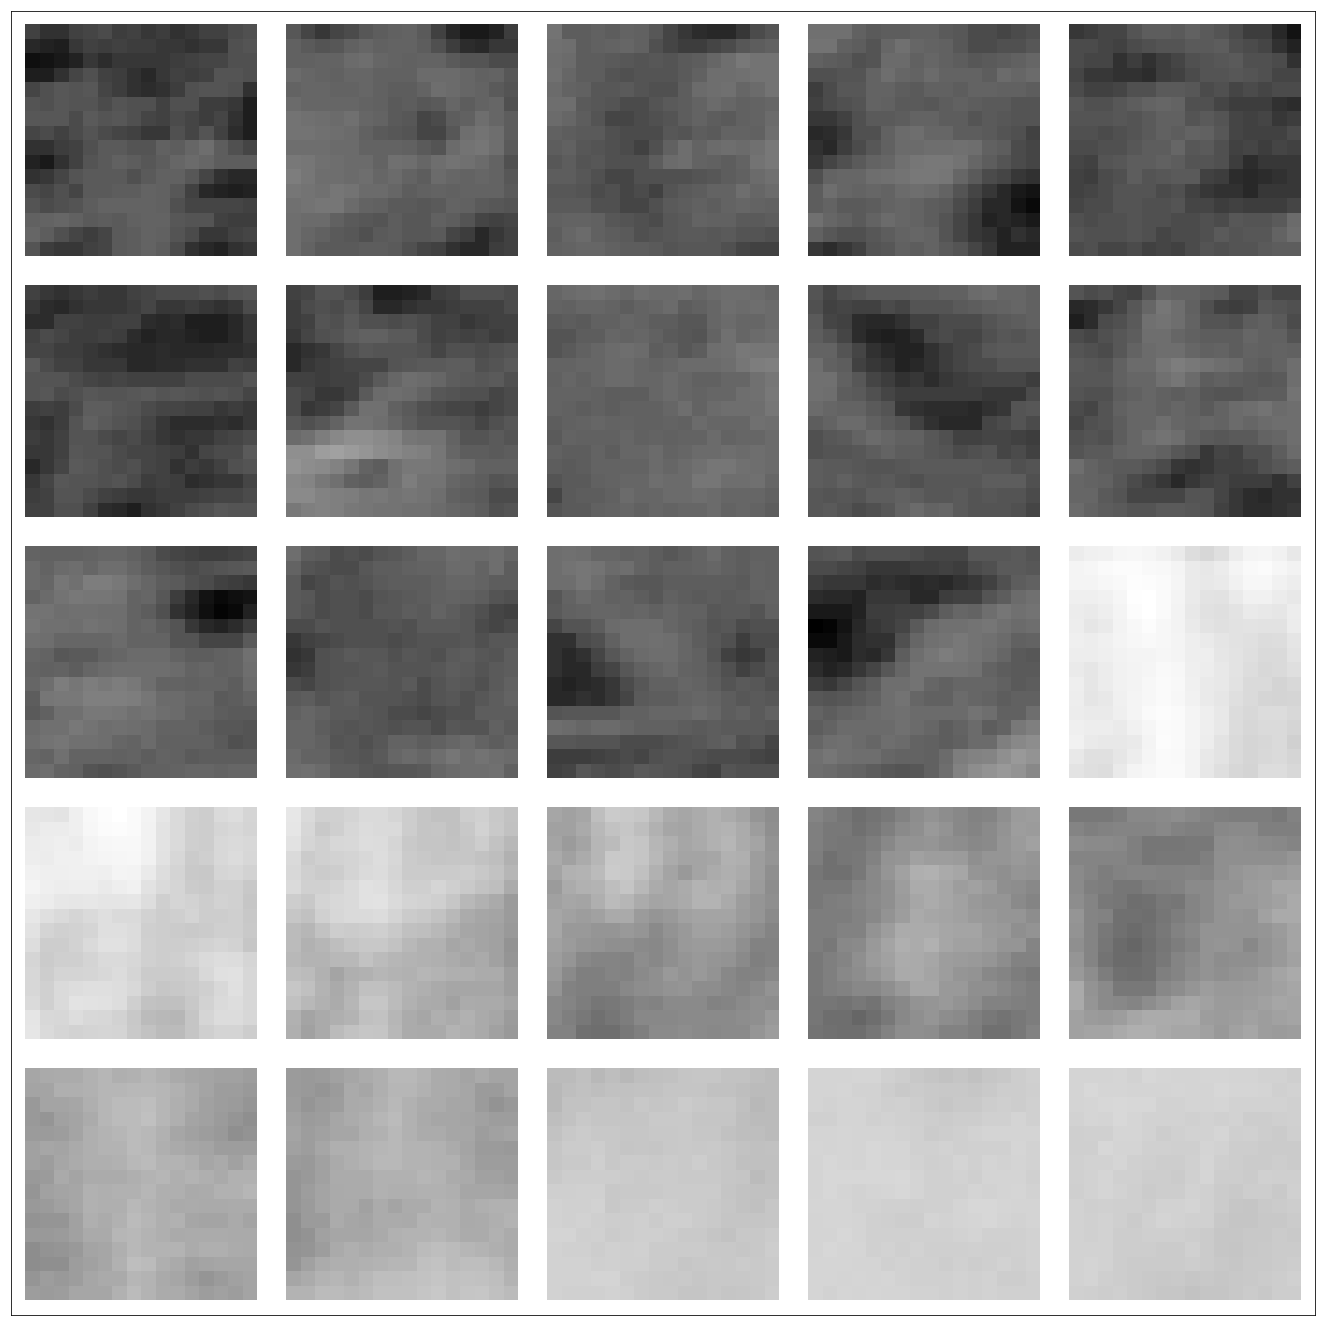

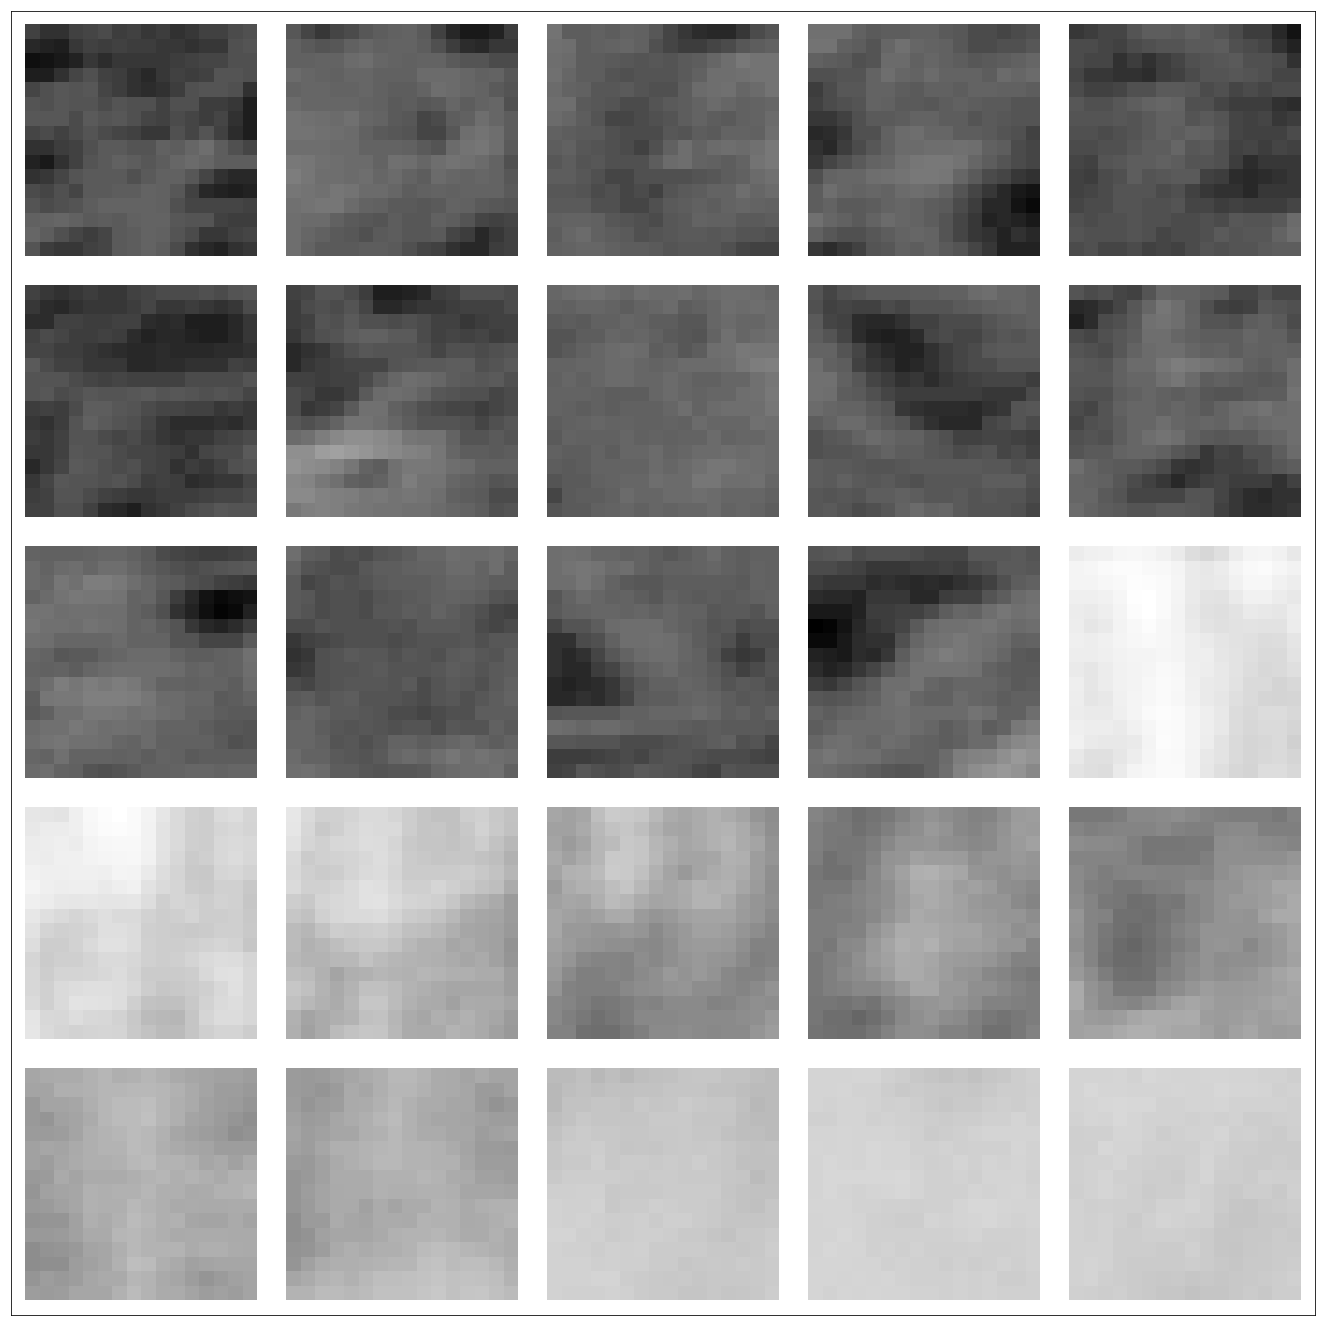

In [28]:
pf.plot_data_tiled(data['train'].images[50:75])

In [29]:
np.mean(data['train'].images)

-4.7031369376782094e-08

In [35]:
np.min(data['train'].images)

-24.666613

In [36]:
np.max(data['train'].images)

34.953434

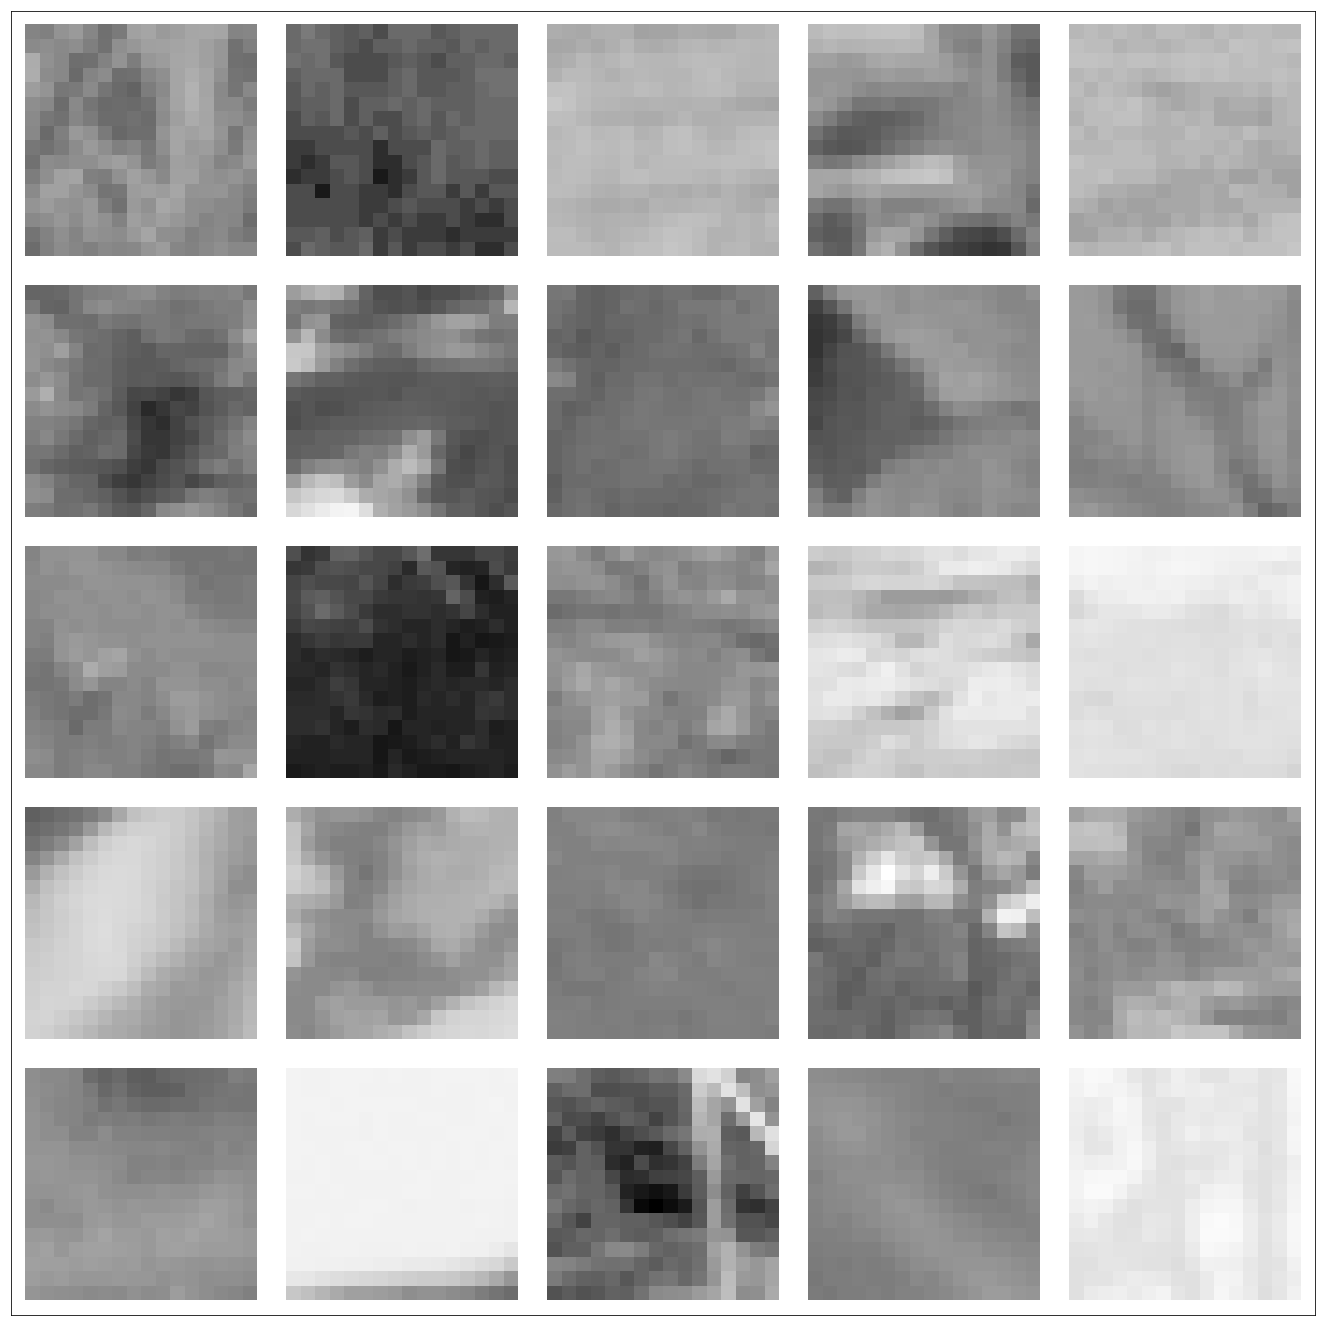

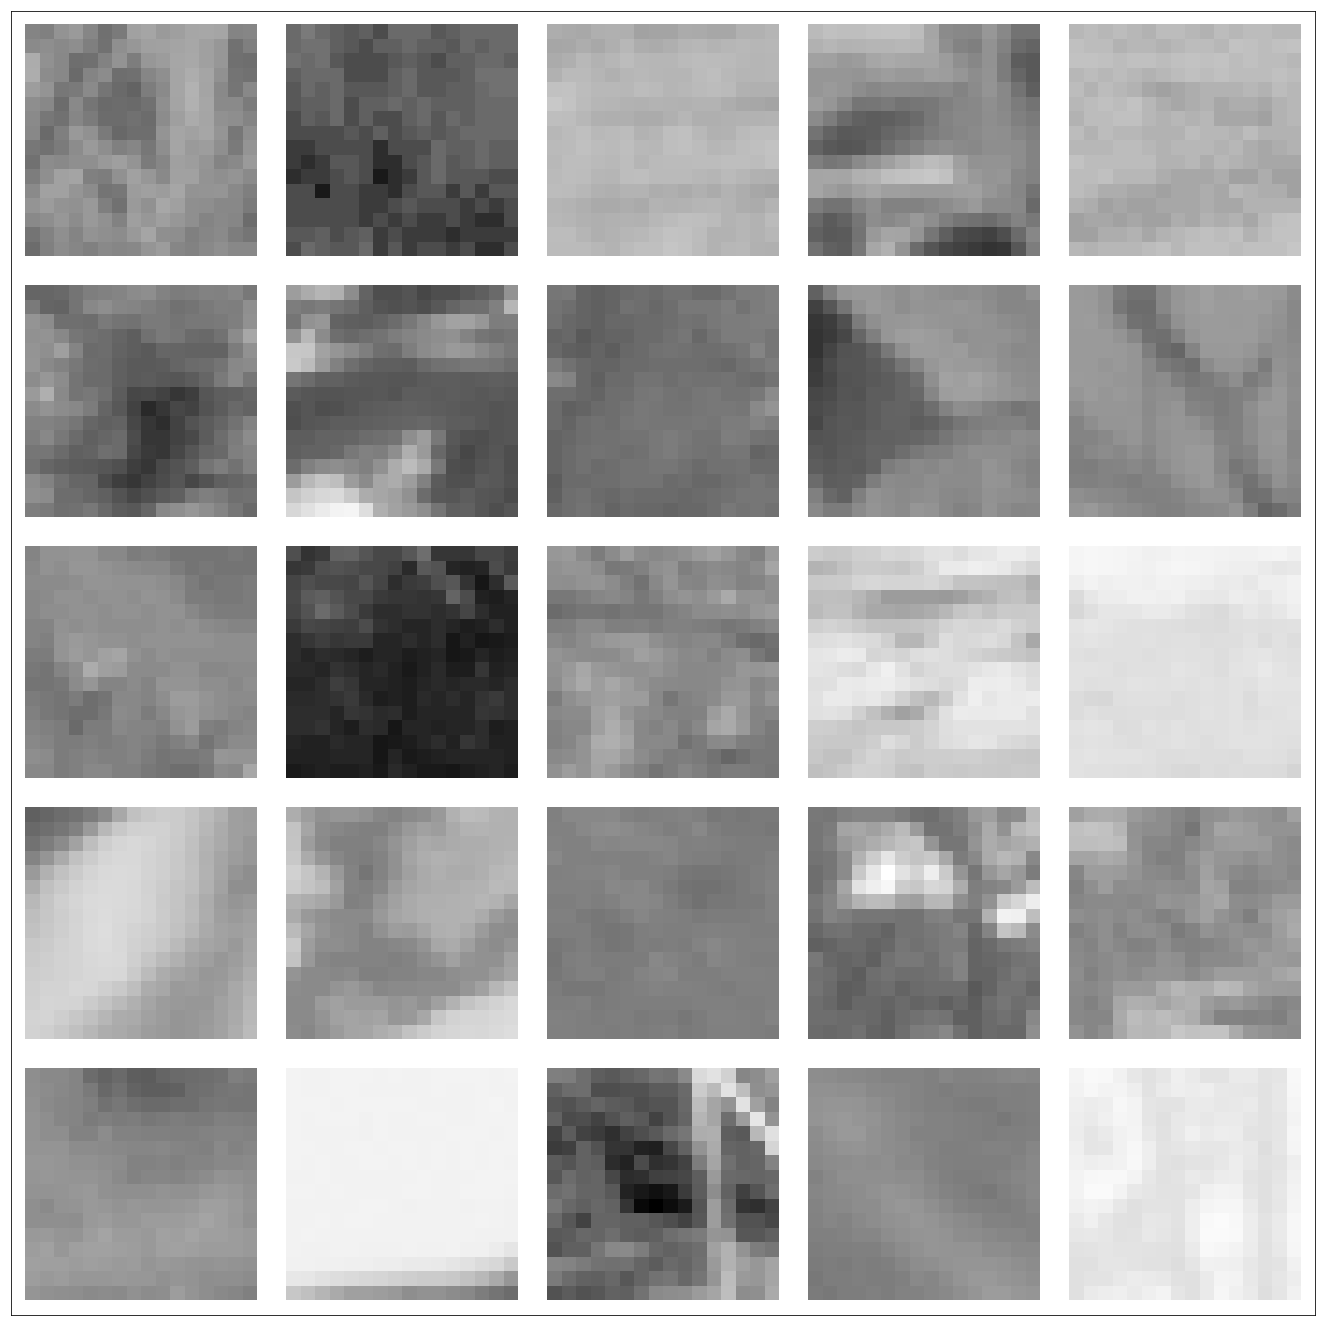

In [36]:

pf.plot_data_tiled(data['train'].images[25:50])

In [72]:
np.savez(params["out_dir"] + 'test_zca_wht.npz', data)

## Testing data

### Tiled

In [41]:
params = {
  "data_type": "vanHateren",
  "num_images": 1,
  "extract_patches": True,
  "num_patches": 4096,
  "patch_edge_size": 16,
  "overlapping_patches": False,
  "randomize_patches": False,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "ZCA",
  "center_data": True,
  "contrast_normalize": False,
  "standardize_data": False,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [42]:
data = ds.get_data(params)
model = mp.get_model(model_type)
data = model.preprocess_dataset(data, params)

In [43]:
D = data['train']

In [46]:
unwhite = dp.unwhiten_data(D.images, D.data_mean, D.w_filter, method=params["whiten_method"])

In [49]:
data['train'].images.shape

(4096, 16, 16, 1)

In [53]:
unwhite

(1, 1024, 1024, 1)

In [50]:
img = dp.patches_to_image(unwhite, (1024, 1024, 1))

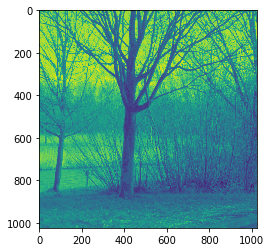

In [56]:
plt.imshow(img.squeeze())

In [57]:
data = model.reshape_dataset(data, params)

In [58]:
np.savez(params["out_dir"] + 'test_zca_wht_tiled.npz', data)

# Baboon, PCA whitened

In [38]:
params = {
  "num_images": 1,
  "extract_patches": True,
  "num_patches": 1024,
  "patch_edge_size": 16,
  "overlapping_patches": False,
  "randomize_patches": False,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "ZCA",
  "center_data": False,
  "contrast_normalize": False,
  "standardize_data": False,
  "data_dir": "/media/tbell/sanborn/rd_analysis/inputs/baboon_gray.png",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [45]:
img = np.array(imageio.imread(params["data_dir"]), dtype='float64')
img = np.reshape(img, (1, 512, 512, 1))

# img = np.reshape(dp.standardize_data(img), (1, 512, 512))
# if params["whiten_data"] == True:
#     img = dp.whiten_data(img, params["whiten_method"])  

dataset = {'train': Dataset(img, lbls=None, ignore_lbls=None)}

# img.preprocess(params)
# img.num_images = params["num_images"]
# data = {'train': img}    
# img = dp.extract_tiled_patches(img, (1024, 256))
# img = np.reshape(img, (1024, 256))

for key in dataset.keys():
  if "center_data" in params.keys() and params["center_data"]:
    dataset[key].images, dataset[key].data_mean = dp.center_data(dataset[key].images,
      use_dataset_mean=True)
    self.data_mean = dataset[key].data_mean
  if "whiten_data" in params.keys() and params["whiten_data"]:
    if "whiten_method" in params.keys():
      if params["whiten_method"] == "FT": # other methods require patching first
        dataset[key].images, dataset[key].data_mean, dataset[key].w_filter = \
          dp.whiten_data(dataset[key].images, method=params["whiten_method"])
  if "contrast_normalize" in params.keys() and params["contrast_normalize"]:
    if "gauss_patch_size" in params.keys():
      dataset[key].images = dp.contrast_normalize(dataset[key].images,
        params["gauss_patch_size"])
    else:
      dataset[key].images = dp.contrast_normalize(dataset[key].images)
  if "extract_patches" in params.keys() and params["extract_patches"]:
    assert all(key in params.keys()
      for key in ["num_patches", "patch_edge_size", "overlapping_patches",
      "randomize_patches"]), ("Insufficient params for patches.")
    out_shape = (int(params["num_patches"]), int(params["patch_edge_size"]),
      int(params["patch_edge_size"]), dataset[key].num_channels)
    dataset[key].num_examples = out_shape[0]
    dataset[key].reset_counters()
    if "patch_variance_threshold" in params.keys():
      dataset[key].images = dp.extract_patches(dataset[key].images, out_shape,
        params["overlapping_patches"], params["randomize_patches"],
        params["patch_variance_threshold"], dataset[key].rand_state)
    else:
      dataset[key].images = dp.extract_patches(dataset[key].images, out_shape,
        params["overlapping_patches"], params["randomize_patches"],
        var_thresh=0, rand_state=dataset[key].rand_state)
    dataset[key].shape = dataset[key].images.shape
    dataset[key].num_rows = dataset[key].shape[1]
    dataset[key].num_cols = dataset[key].shape[2]
    dataset[key].num_channels = dataset[key].shape[3]
    dataset[key].num_pixels = np.prod(dataset[key].shape[1:])
  if "whiten_data" in params.keys() and params["whiten_data"]:
    if "whiten_method" in params.keys() and params["whiten_method"] != "FT":
      dataset[key].images, dataset[key].data_mean, dataset[key].w_filter = \
        dp.whiten_data(dataset[key].images, method=params["whiten_method"])
  if "norm_data" in params.keys() and params["norm_data"]:
    dataset[key].images, dataset[key].data_max = dp.normalize_data_with_max(dataset[key].images)
  if "norm_data_to_one" in params.keys() and params["norm_data"]:
    dataset[key].images = dp.rescale_data_to_one(dataset[key].images)
  if "standardize_data" in params.keys() and params["standardize_data"]:
    dataset[key].images, dataset[key].data_mean, dataset[key].data_std = \
      dp.standardize_data(dataset[key].images)
    self.data_mean = dataset[key].data_mean
    self.data_std = dataset[key].data_std

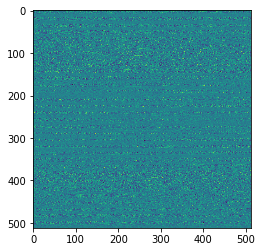

In [48]:
plt.imshow(np.reshape(dataset['train'].images, (512,512)))

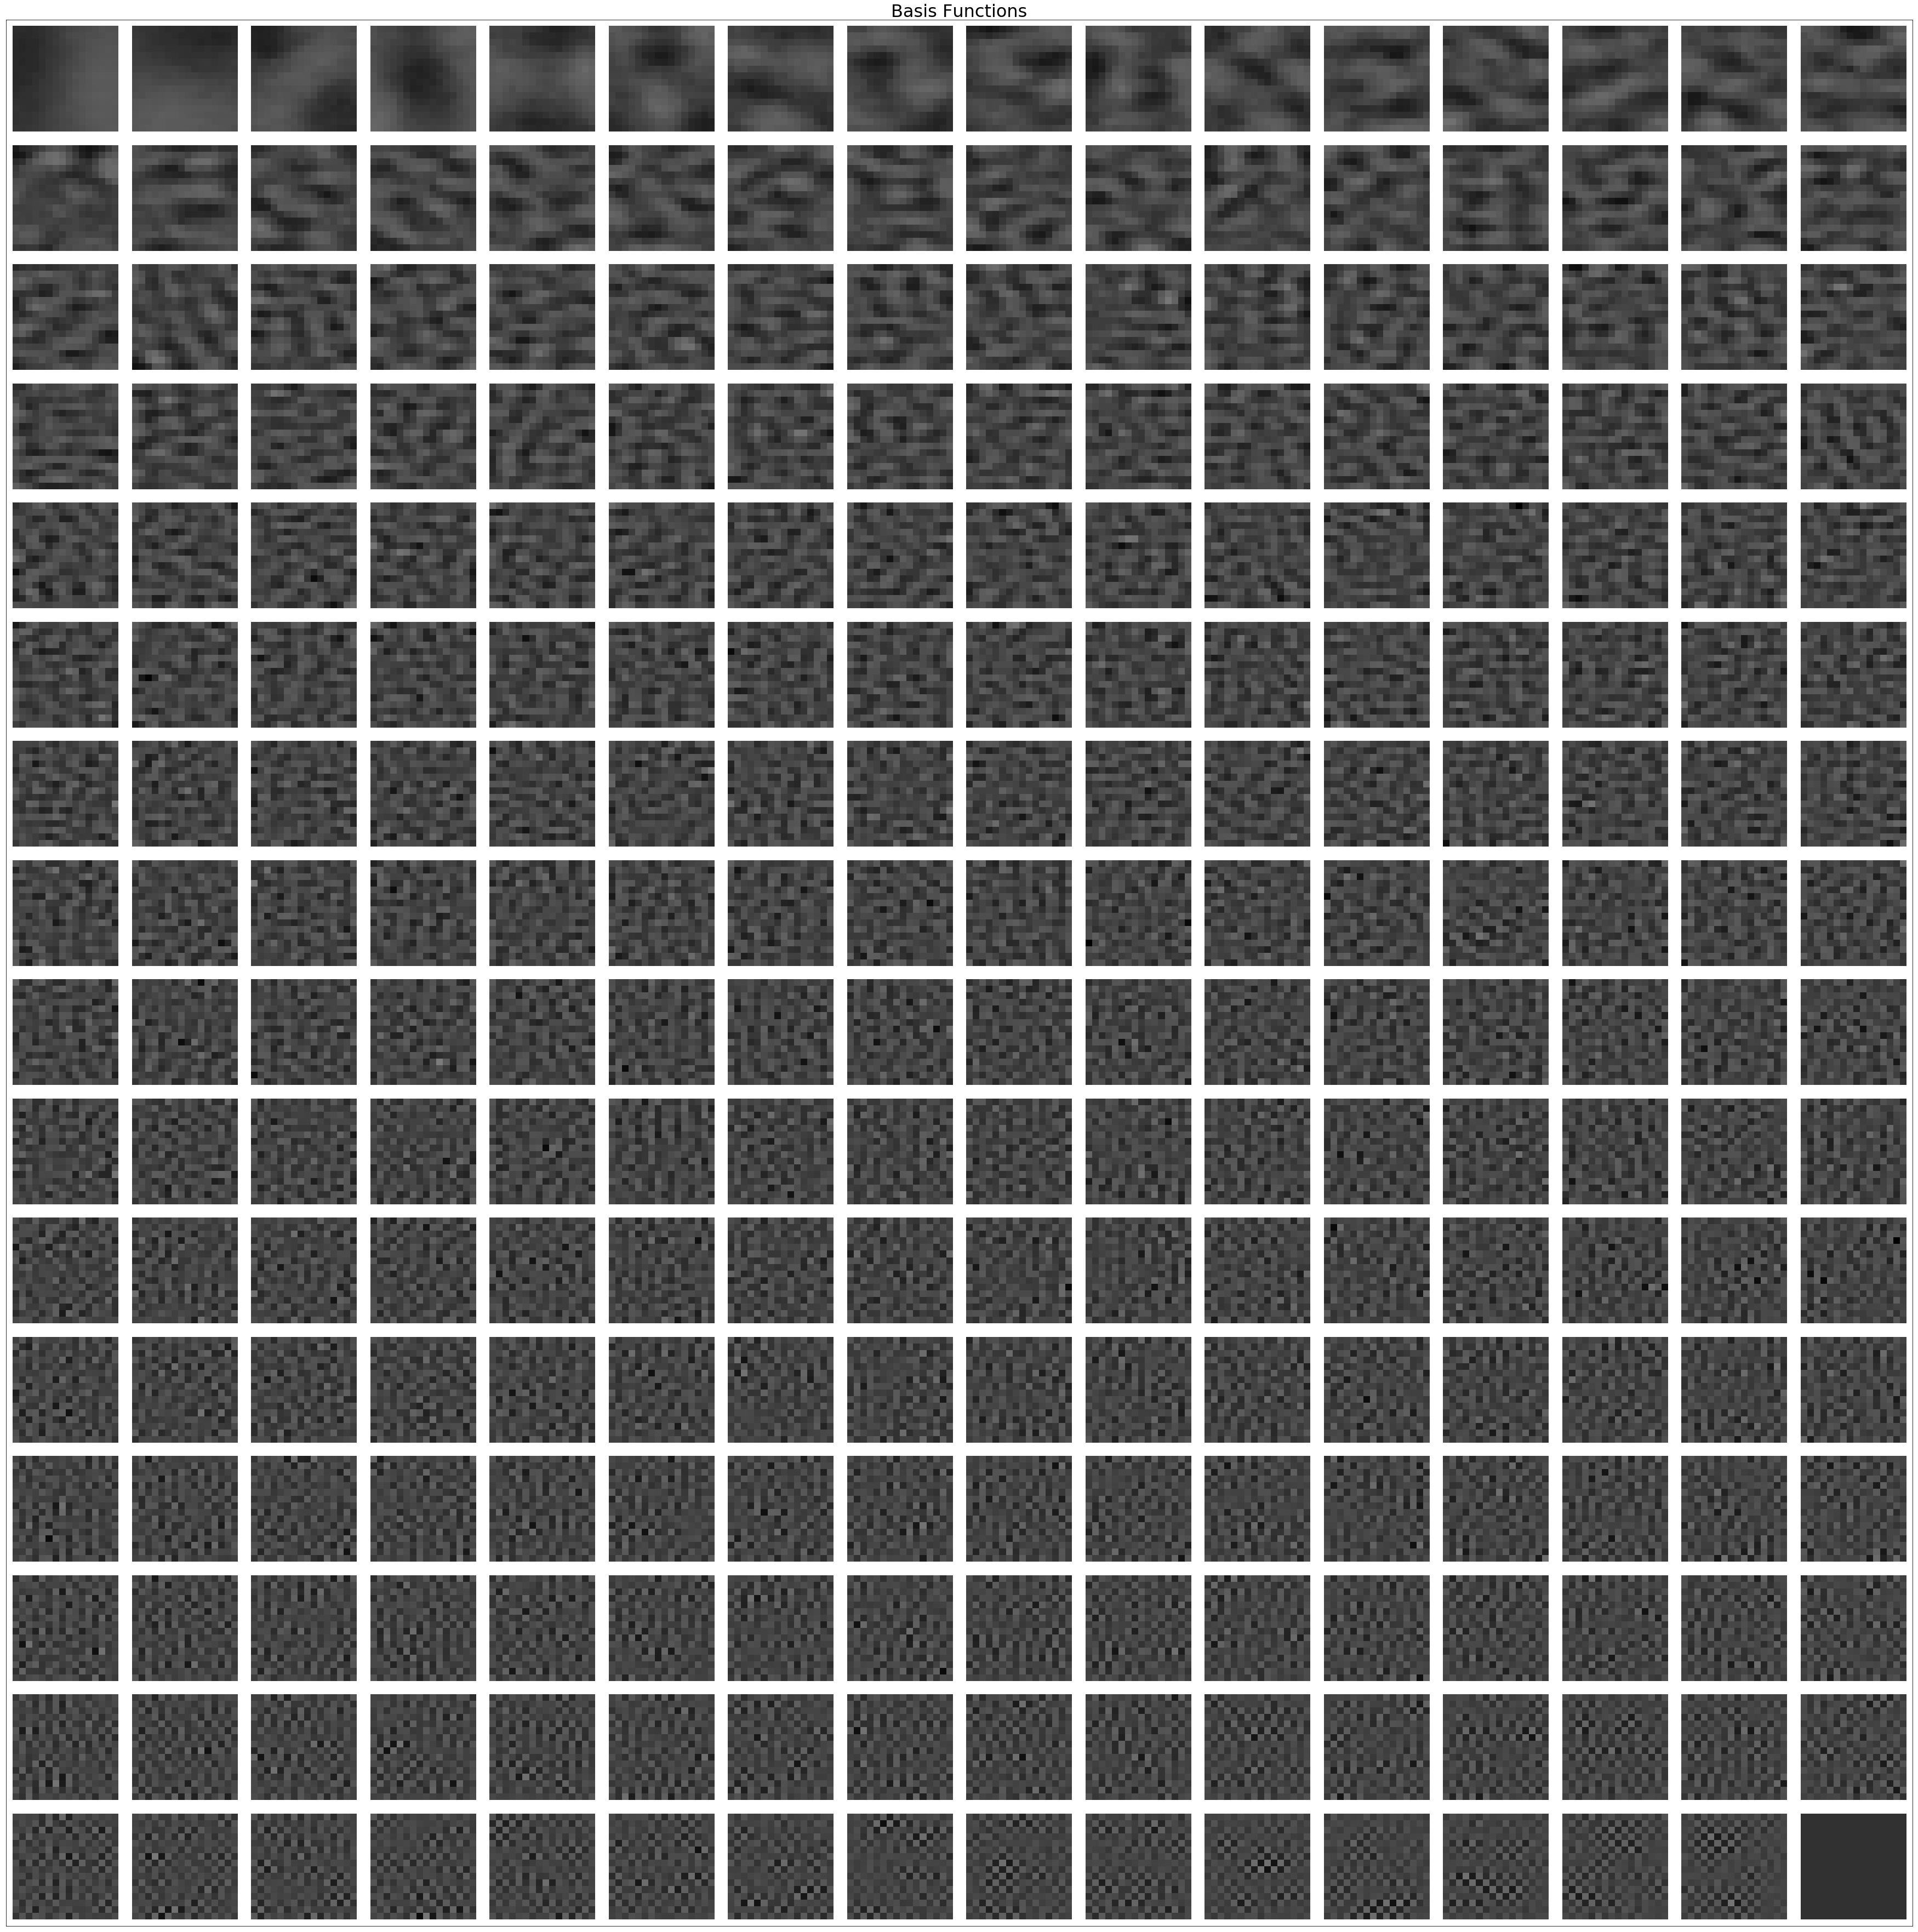

In [6]:
pf.plot_bases(data["train"].pca_matrix)

In [6]:
patch_data_dim = (params['num_patches'], params['patch_edge_size'], params['patch_edge_size'])
recon = dp.patches_to_image(np.reshape(data["train"].images, patch_data_dim), params['num_images'], 512)

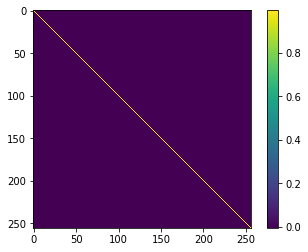

In [124]:
plt.imshow(np.divide(np.dot(data['train'].images.T, data['train'].images), data['train'].images.shape[0]))
plt.colorbar()

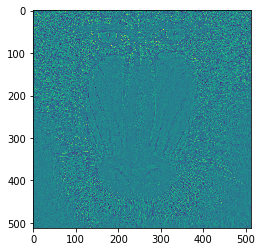

In [78]:
plt.imshow(recon)

In [7]:
np.savez('/media/tbell/sanborn/rd_analysis/inputs/baboon_zca_wht.npz', data)

## Overlapping

In [4]:
params = {
  "data_type": "vanHateren",
  "num_images": 1,
  "extract_patches": True,
  "num_patches": 100000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": False,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": False,
  "contrast_normalize": False,
  "standardize_data": True,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [5]:
data = ds.get_data(params)

In [6]:
np.savez(params["out_dir"] + 'test_100000.npz', data)

# Training data, overlapping, PCA whitened

In [2]:
params = {
  "data_type": "vanHateren",
  "num_images": 50,
  "extract_patches": True,
  "num_patches": 1000000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "PCA",
  "contrast_normalize": False,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [3]:
data = ds.get_data(params)

MemoryError: 

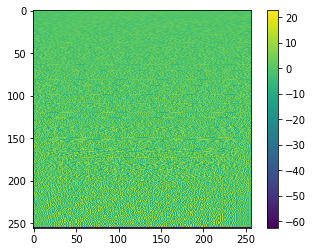

In [6]:
plt.imshow(data['train'].w_filter)
plt.colorbar()

In [7]:
np.savez(params["out_dir"] + 'train_pca_wht.npz', data)

# Training data, overlapping, ZCA whitened


In [56]:
params = {
  "data_type": "vanHateren",
  "num_images": 100,
  "extract_patches": True,
  "num_patches": 1000000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "ZCA",
  "contrast_normalize": False,
  "standardize_data": False,
  "center_data": True,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [57]:
data = ds.get_data(params)
data = model.preprocess_dataset(data, params)
data = model.reshape_dataset(data, params)

In [61]:
data['train'].images.shape

(1000000, 256)

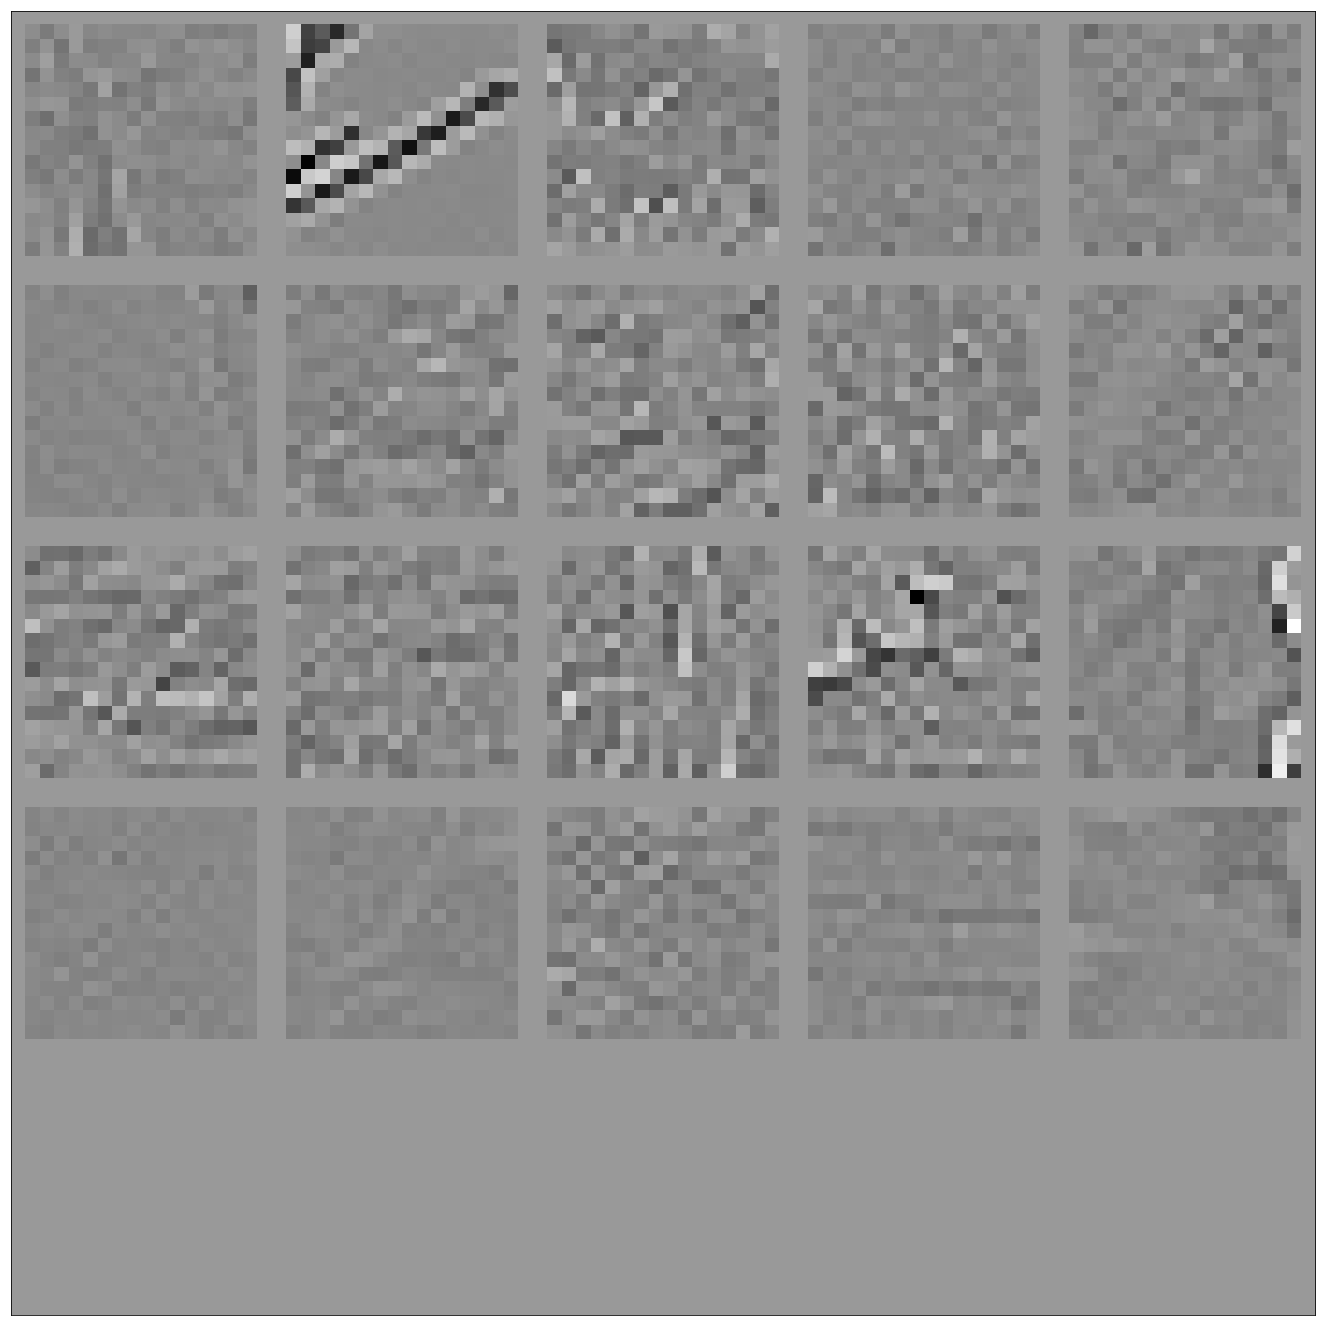

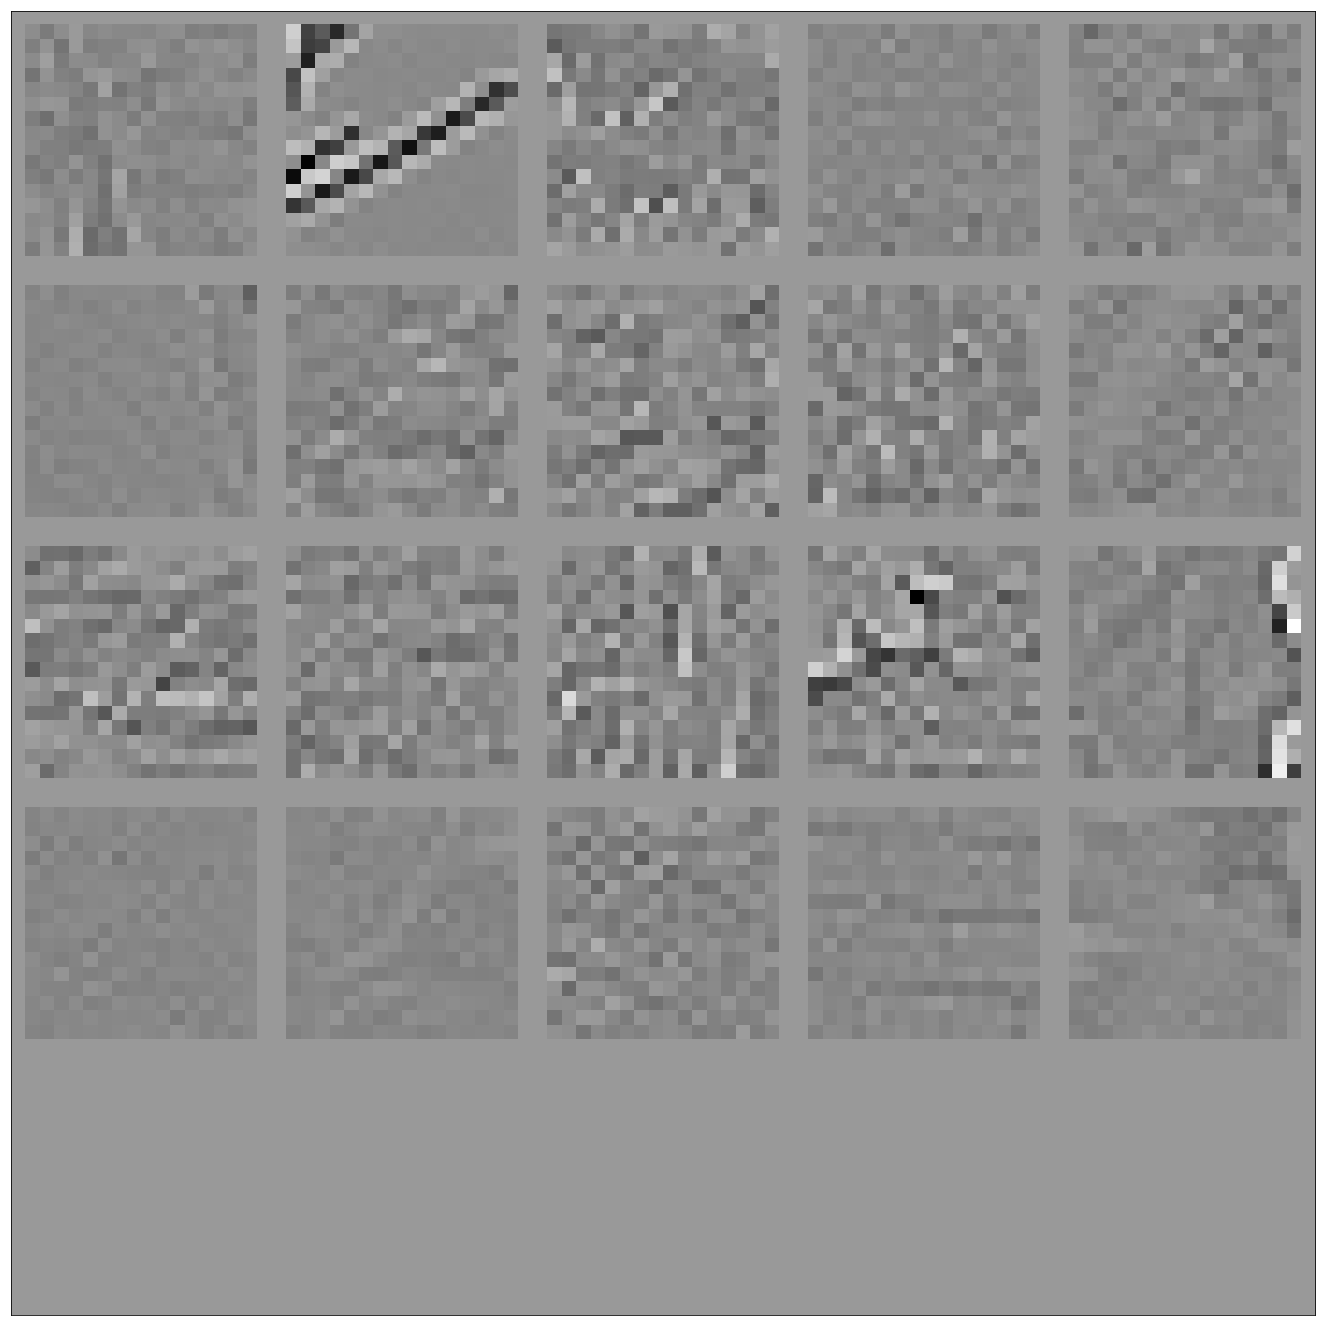

In [60]:
pf.plot_data_tiled(data['train'].images[:20])

In [14]:
data['train'].w_filter[1].shape

(256, 256)

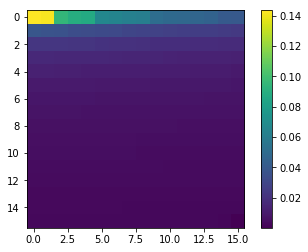

In [16]:
plt.imshow(np.reshape(data['train'].w_filter[1], (16, 16)))
plt.colorbar()

In [62]:
np.savez(params["out_dir"] + 'train_zca_wht_3.npz', data)

# Training data, overlapping, FT whitened

In [4]:
params = {
  "data_type": "vanHateren",
  "num_images": 50,
  "extract_patches": True,
  "num_patches": 1000000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "FT",
  "contrast_normalize": False,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [5]:
data = ds.get_data(params)

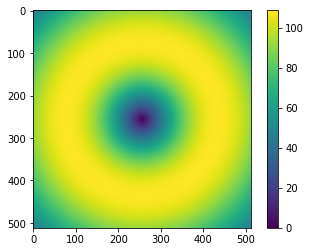

In [6]:
plt.imshow(data['train'].w_filter)
plt.colorbar()

In [7]:
np.savez(params["out_dir"] + 'train_ft_wht.npz', data)

# Testing data, overlapping, PCA whitened

In [11]:
params = {
  "data_type": "vanHateren",
  "num_images": 50,
  "extract_patches": True,
  "num_patches": 100000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "PCA",
  "contrast_normalize": False,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [12]:
data = ds.get_data(params)

In [13]:
np.savez(params["out_dir"] + 'test_pca_wht.npz', data)

# Testing data, overlapping, ZCA whitened

In [2]:
params = {
  "data_type": "vanHateren",
  "num_images": 50,
  "extract_patches": True,
  "num_patches": 100000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "ZCA",
  "contrast_normalize": False,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [3]:
data = ds.get_data(params)

# Testing data, overlapping, FT whitened

In [17]:
params = {
  "data_type": "vanHateren",
  "num_images": 50,
  "extract_patches": True,
  "num_patches": 100000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "FT",
  "contrast_normalize": False,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [18]:
data = ds.get_data(params)

In [19]:
np.savez(params["out_dir"] + 'test_ft_wht.npz', data)